In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
import time

In [4]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [6]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [7]:
# build the dataset
block_size = 15 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 15]) torch.Size([182625])
torch.Size([22655, 15]) torch.Size([22655])
torch.Size([22866, 15]) torch.Size([22866])


In [6]:
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Embedding:
  
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))
    
  def __call__(self, IX):
    self.out = self.weight[IX].transpose(1, 2)
    
    return self.out
  
  def parameters(self):
    return [self.weight]

# -----------------------------------------------------------------------------------------------
class FlattenConsecutive:
  
  def __init__(self, n):
    self.n = n
    
  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out
  
  def parameters(self):
    return []

class Flatten:
    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out
    def parameters(self):
        return []

# -----------------------------------------------------------------------------------------------
class Sequential:
  
  def __init__(self, layers):
    self.layers = layers
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]

# --------------------------------------------
class Conv1d:
    def __init__(self, sequence_length, in_channels, out_channels, kernel=2, stride=1, dilation=1):
        self. sequence_length = sequence_length
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel = kernel
        self.stride = stride
        self.dilation = dilation
        self.filters = torch.randn((out_channels, in_channels, kernel)) * 0.1
        self.bias = torch.randn(out_channels) * 0
    def __call__(self, x):
        # Compute effective kernel size based on dilation 
        effective_kernel = ((self.kernel - 1) * self.dilation) + 1
        
        N, C, L = x.shape
        assert effective_kernel <= L
            
        # create the sliding windows of the input 
        x_unfolded = x.unfold(2, effective_kernel, self.stride)

        # Extract dilated inputs from x_unfolded which used effective_kernel. The shape of the unfolded vector is [N, C, L, effective_k] 
        # where L is the length of the sequence depending on the effective kernel. From the dimension of effective_kernel, we clip every 'dilated' index
        # If effective_kernel is 3 and dilation is 2, [1, 2, 3] will result in [1, 3]. [1,3] has length of 2, which is equal to actual kernel value
        x_unfolded = x_unfolded[:, :, :, ::self.dilation]

        # The dilation also changes the sequence length, since effective kernel value changes with dilation > 1. 
        # Compute Lout based on effective_kernel
        
        Lout = ((self.sequence_length - effective_kernel) // self.stride) + 1
        
        # Before cross correlation, we need to broadcast the filters and the input correctly
        x_unfolded = x_unfolded.view(N, 1, C, Lout, self.kernel)
        filters = self.filters.view(1, self.out_channels, self.in_channels, 1, self.kernel)

        # Perform element wise multiplication
        self.out = torch.mul(x_unfolded, filters).sum((2, 4)) + self.bias.view(1, self.out_channels, 1)
        return self.out        
    
    def parameters(self): 
        return [self.filters] + [self.bias]

class ReLu: 
    def __call__(self, x):
        self.out = torch.relu(x)
        return self.out

    def parameters(self):
        return []
        
class Transpose:
    def __call__(self, x):
        self.out = x.transpose(1, 2)
        return self.out
    
    def parameters(self):
        return []

In [7]:
def get_Lout(sequence_length, kernel, dilation, stride):
    effective_kernel = (kernel - 1) * dilation + 1
    Lout = ((sequence_length - effective_kernel) // stride) + 1
    return Lout
    
### Let's redefine the model with conv layers 
n_embedding = 10

# conv1d_1
n_conv1_out_channels = 20
n_conv1_stride = 1 
n_conv1_kernel = 2
n_conv1_dilation = 1

# Compute Lout based on effective kernel using dilation, instead of actual kernel
conv1_L_out = get_Lout(block_size, n_conv1_kernel, n_conv1_dilation, n_conv1_stride)
# conv1_L_out = ((block_size - n_conv1_kernel) // n_conv1_stride) + 1
print("conv1_L_out: ", conv1_L_out)
# conv1d_2
n_conv2_out_channels = 30
n_conv2_stride = 1 
n_conv2_kernel = 3
n_conv2_dilation = 2
conv2_L_out = get_Lout(conv1_L_out, n_conv2_kernel, n_conv2_dilation, n_conv2_stride)
# conv2_L_out = ((conv1_L_out - n_conv2_kernel) // n_conv2_stride) + 1
print("conv2_L_out: ", conv2_L_out)

# conv1d_3
n_conv3_out_channels = 40
n_conv3_stride = 1 
n_conv3_kernel = 3
n_conv3_dilation = 2
conv3_L_out = get_Lout(conv2_L_out, n_conv3_kernel, n_conv3_dilation, n_conv3_stride)
# conv3_L_out = ((conv2_L_out - n_conv3_kernel) // n_conv3_stride) + 1
print("conv3_L_out: ", conv3_L_out)

#h1
n_h1_fanout = 100

#h2
n_h2_fanout = 100

model = Sequential([
    Embedding(vocab_size, n_embedding), 
    Conv1d(sequence_length=block_size, in_channels=n_embedding, out_channels=n_conv1_out_channels, kernel=n_conv1_kernel, stride=n_conv1_stride), ReLu(),
    Conv1d(sequence_length=conv1_L_out, in_channels=n_conv1_out_channels, out_channels=n_conv2_out_channels, kernel=n_conv2_kernel, stride=n_conv2_stride, dilation=2), ReLu(),
    Conv1d(sequence_length=conv2_L_out, in_channels=n_conv2_out_channels, out_channels=n_conv3_out_channels, kernel=n_conv3_kernel, stride=n_conv3_stride, dilation=2), ReLu(),

    Flatten(), Linear(fan_in=n_conv3_out_channels * conv3_L_out, fan_out=n_h1_fanout), Tanh(),
    Linear(fan_in=n_h1_fanout, fan_out=n_h2_fanout), Tanh(),
    Linear(fan_in=n_h1_fanout, fan_out=vocab_size)
])



with torch.no_grad():
    model.layers[-1].weight *= 0.1

# parameters = [p for layer in layers for p in layer.parameters()]
print(f"parameters: {sum(p.nelement() for p in model.parameters())}")

for p in model.parameters():
    p.requires_grad = True

conv1_L_out:  14
conv2_L_out:  10
conv3_L_out:  6
parameters: 43087


In [ ]:
# same optimization as last time
max_steps = 200_000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function
  
  for p in model.parameters():
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in model.parameters():
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

In [14]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

In [221]:
split_loss('train')
split_loss('val')

train 1.8569831848144531
val 2.029000997543335


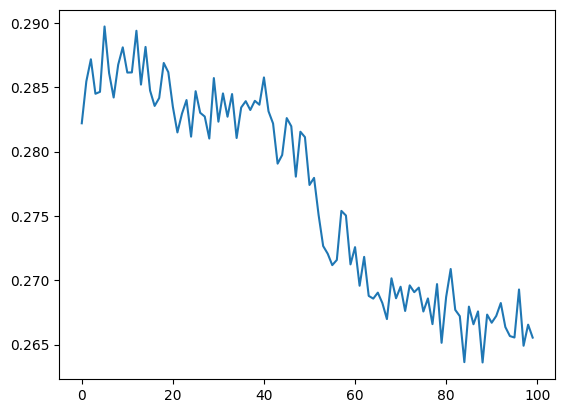

In [222]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

### Performance log 
#### with 40 filter size of each conv layer, 10 dimensional embedding
* train 1.9566978216171265
* val 2.0483827590942383

#### With 20, 30, 40 filters (increasing by 10 at each layer), 10 dimensional embedding
* train 1.911450743675232
* val 2.0312490463256836
#### Trained the above for another 50k epochs with 0.01 learning rate
* train 1.8932315111160278
* val 2.0289735794067383

#### Introduced dilated convolutional networks. Reduced the complexity of the model. Hirarchical layer removed and a linear 100 neuron layer added. Parameter count also reduced, yet got almost similar val loss, with smaller network. Block size = 8. The names sampled were much more diverse this time.
* train 1.904414415359497
* val 2.0429046154022217

#### Increased the block size to 15. Kernel of conv2 and conv3 to 3 and dilations remained same.
* train 1.8675997257232666
* val 2.0497312545776367

#### Added another hidden layer of 100 neurons and now the validation loss has come down. 
* train 1.86508047580719
* val 2.037341833114624

#### Ran for another 100k epochs with 0.05 lr reduced to 0.01 after 50k iterations
* train 1.8569831848144531
* val 2.029000997543335
#### Adding residual layer around conv1d layers did not impact the loss, mainly because the network is very shallow right now
* train 1.8663831844748521
* val 2.04
#### We reduced the parameter count from 80k to 29k simply by using identity mapping in residual layer. The training time increased. The val loss slightly worsened but that is because each conv layer has now 10 channels only (to maintain identity mapping of the residual layer).
* train 1.89764404296875
* val 2.079698085784912

#### We introduced bottleneck architecture residual layers around first 2 conv layers. In the first residual layer, there is a downsampler which downsamples channels from 24 to 15. Then passes to conv layer. Then an upsampler that restores channel count to 24. Then there is an upsampler 1x1 conv layer which upsamples channel count to 40. Then another residual layer which downsamples to 15, passes through conv layer, then upsamples to 40. Then there is another conv which upsamples to 60 with a kernel size of 2. 
* train 1.9474365711212158
* val 2.0514471530914307


In [226]:
# sample from the model
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

eldiea.
jermar.
yurder.
joseja.
taorance.
thorsis.
adriella.
leniya.
xadata.
aryanaed.
auxgan.
ilisia.
khaleian.
andrey.
elio.
ereckel.
daviya.
ahris.
ariza.
mackh.


### Adding residual connections!


In [8]:
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # Parameters (trainable via backprop)
    self.gamma = torch.ones(dim).view(1, -1, 1)  # Shape [1, C, 1]
    self.beta = torch.zeros(dim).view(1, -1, 1)  # Shape [1, C, 1]
    # Buffers (updated via momentum)
    self.running_mean = torch.zeros(dim)  # Shape [C]
    self.running_var = torch.ones(dim)    # Shape [C]
  
  def __call__(self, x):
    if self.training:
      # Compute mean and variance across batch and sequence length (dim=(0,2))
      xmean = x.mean(dim=(0, 2), keepdim=True)  # Shape [1, C, 1]
      xvar = x.var(dim=(0, 2), keepdim=True)    # Shape [1, C, 1]
    else:
      # Use running statistics for inference
      xmean = self.running_mean.view(1, -1, 1)  # Shape [1, C, 1]
      xvar = self.running_var.view(1, -1, 1)    # Shape [1, C, 1]
    
    # Normalize input
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps)  # Normalize to unit variance
    self.out = self.gamma * xhat + self.beta         # Scale and shift

    # Update running statistics during training
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean.squeeze()
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar.squeeze()
    
    return self.out
  
  def parameters(self):
    # Return trainable parameters
    return [self.gamma, self.beta]


# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Embedding:
  
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))
    
  def __call__(self, IX):
    self.out = self.weight[IX].transpose(1, 2)
    
    return self.out
  
  def parameters(self):
    return [self.weight]

# -----------------------------------------------------------------------------------------------
class FlattenConsecutive:
  
  def __init__(self, n):
    self.n = n
    
  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out
  
  def parameters(self):
    return []

class Flatten:
    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out
    def parameters(self):
        return []

# -----------------------------------------------------------------------------------------------
class Sequential:
  
  def __init__(self, layers):
    self.layers = layers
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]

# --------------------------------------------
class Conv1d:
    def __init__(self, sequence_length, in_channels, out_channels, kernel=2, stride=1, dilation=1):
        self. sequence_length = sequence_length
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel = kernel
        self.stride = stride
        self.dilation = dilation
        self.filters = torch.randn((out_channels, in_channels, kernel)) * ((2 / (in_channels * kernel)) ** 0.5)
        self.bias = torch.randn(out_channels) * 0
        self.effective_kernel = ((self.kernel - 1) * self.dilation) + 1
        self.Lout = ((self.sequence_length - self.effective_kernel) // self.stride) + 1
    def __call__(self, x):
        # Compute effective kernel size based on dilation 
        # effective_kernel = ((self.kernel - 1) * self.dilation) + 1
        
        N, C, L = x.shape
        assert self.effective_kernel <= L
            
        # create the sliding windows of the input 
        x_unfolded = x.unfold(2, self.effective_kernel, self.stride)

        # Extract dilated inputs from x_unfolded which used effective_kernel. The shape of the unfolded vector is [N, C, L, effective_k] 
        # where L is the length of the sequence depending on the effective kernel. From the dimension of effective_kernel, we clip every 'dilated' index
        # If effective_kernel is 3 and dilation is 2, [1, 2, 3] will result in [1, 3]. [1,3] has length of 2, which is equal to actual kernel value
        x_unfolded = x_unfolded[:, :, :, ::self.dilation]

        # The dilation also changes the sequence length, since effective kernel value changes with dilation > 1. 
        # Compute Lout based on effective_kernel
        
        # Lout = ((self.sequence_length - self.effective_kernel) // self.stride) + 1
        
        # Before cross correlation, we need to broadcast the filters and the input correctly
        x_unfolded = x_unfolded.view(N, 1, C, self.Lout, self.kernel)
        filters = self.filters.view(1, self.out_channels, self.in_channels, 1, self.kernel)

        # Perform element wise multiplication
        self.out = torch.mul(x_unfolded, filters).sum((2, 4)) + self.bias.view(1, self.out_channels, 1)
        return self.out        
    
    def parameters(self): 
        return [self.filters] + [self.bias]

class ReLu: 
    def __call__(self, x):
        self.out = torch.relu(x)
        return self.out

    def parameters(self):
        return []
        
class Transpose:
    def __call__(self, x):
        self.out = x.transpose(1, 2)
        return self.out
    
    def parameters(self):
        return []

class Residual: 
    def __init__(self, layers):
        self.projection_needed = False
        self.layers = layers
        
        
        # Input of the in layer config
        in_layer = layers[0]
        out_layer = layers[-1]

        self.in_channels = in_layer.in_channels
        self.in_sequence_length = in_layer.sequence_length

        self.out_channels = out_layer.out_channels
        self.out_sequence_length = out_layer.Lout

        if self.in_channels != self.out_channels: # Assuming for now, this will always be the case
            self.projection_needed = True
            self.linear_projection_conv = Conv1d(sequence_length=self.in_sequence_length, out_channels=self.out_channels, in_channels=self.in_channels, kernel=1)
            
    def __call__(self, x):
        self.input = x
        for layer in self.layers: 
            x = layer(x)
        # Perform residual operation
        if self.projection_needed:
            linear_projection = self.linear_projection_conv(self.input)
            
        # Pad the output since the Lout != Lin
        sequence_length_diff = self.in_sequence_length - self.out_sequence_length
        x = F.pad(x, (sequence_length_diff // 2, sequence_length_diff - sequence_length_diff // 2))
        
        self.out = x + linear_projection if self.projection_needed else x + self.input
        
        return self.out
        
    def parameters(self):
        # Collect parameters from all layers and the projection (if used)
        params = [p for layer in self.layers for p in layer.parameters()]
        if self.projection_needed:
            params += self.linear_projection_conv.parameters()
        return params

In [52]:
x = torch.randn((32, 10, 8))
c1 = Conv1d(8, 10, 20)
c2 = Conv1d(7, 20, 20)  # torch.Size([32, 20, 6])

resnet = Residual([c1, ReLu(), c2])
resnet(x).shape
# resnet.layers[2].out_channels

torch.Size([32, 20, 8])

### Let's build our model with residual layers now. 
We will wrap the each conv1d in a residual layer. 

In [60]:
def get_Lout(sequence_length, kernel, dilation, stride):
    effective_kernel = (kernel - 1) * dilation + 1
    Lout = ((sequence_length - effective_kernel) // stride) + 1
    return Lout
    
### Let's redefine the model with conv layers 
n_embedding = 10

# conv1d_1
n_conv1_out_channels = 20
n_conv1_stride = 1 
n_conv1_kernel = 2
n_conv1_dilation = 1

# Compute Lout based on effective kernel using dilation, instead of actual kernel
conv1_L_out = get_Lout(block_size, n_conv1_kernel, n_conv1_dilation, n_conv1_stride)
# conv1_L_out = ((block_size - n_conv1_kernel) // n_conv1_stride) + 1
print("conv1_L_out: ", conv1_L_out)
# conv1d_2
n_conv2_out_channels = 30
n_conv2_stride = 1 
n_conv2_kernel = 3
n_conv2_dilation = 2
conv2_L_out = get_Lout(conv1_L_out, n_conv2_kernel, n_conv2_dilation, n_conv2_stride)
# conv2_L_out = ((conv1_L_out - n_conv2_kernel) // n_conv2_stride) + 1
print("conv2_L_out: ", conv2_L_out)

# conv1d_3
n_conv3_out_channels = 40
n_conv3_stride = 1 
n_conv3_kernel = 3
n_conv3_dilation = 2
conv3_L_out = get_Lout(conv2_L_out, n_conv3_kernel, n_conv3_dilation, n_conv3_stride)
# conv3_L_out = ((conv2_L_out - n_conv3_kernel) // n_conv3_stride) + 1
print("conv3_L_out: ", conv3_L_out)

#h1
n_h1_fanout = 100

#h2
n_h2_fanout = 100

model = Sequential([
    Embedding(vocab_size, n_embedding), 
    Residual([
        Conv1d(sequence_length=block_size, in_channels=n_embedding, out_channels=n_conv1_out_channels, kernel=n_conv1_kernel, stride=n_conv1_stride), ReLu(),
        Conv1d(sequence_length=conv1_L_out, in_channels=n_conv1_out_channels, out_channels=n_conv2_out_channels, kernel=n_conv2_kernel, stride=n_conv2_stride, dilation=2), ReLu(),
        Conv1d(sequence_length=conv2_L_out, in_channels=n_conv2_out_channels, out_channels=n_conv3_out_channels, kernel=n_conv3_kernel, stride=n_conv3_stride, dilation=2), 
    ]),
    ReLu(),
    # Output of residual will be the [out_channels, input_sequence_length of the layer before the residual layer]
    Flatten(), Linear(fan_in=n_conv3_out_channels * block_size, fan_out=n_h1_fanout), Tanh(),
    Linear(fan_in=n_h1_fanout, fan_out=n_h2_fanout), Tanh(),
    Linear(fan_in=n_h1_fanout, fan_out=vocab_size)
])



with torch.no_grad():
    model.layers[-1].weight *= 0.1

# parameters = [p for layer in layers for p in layer.parameters()]
print(f"parameters: {sum(p.nelement() for p in model.parameters())}")

for p in model.parameters():
    p.requires_grad = True

conv1_L_out:  14
conv2_L_out:  10
conv3_L_out:  6
parameters: 79527


In [65]:
# same optimization as last time
max_steps = 200_000
batch_size = 32
# lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function
  
  for p in model.parameters():
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.05 if i < 100000 else 0.001 # step learning rate decay
  for p in model.parameters():
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())


      0/ 200000: 1.6993
  10000/ 200000: 2.0160
  20000/ 200000: 1.3258
  30000/ 200000: 1.8583
  40000/ 200000: 1.8102
  50000/ 200000: 1.7424
  60000/ 200000: 1.6037
  70000/ 200000: 1.8541
  80000/ 200000: 1.9159
  90000/ 200000: 1.9372
 100000/ 200000: 1.8772
 110000/ 200000: 1.5870
 120000/ 200000: 1.7653
 130000/ 200000: 2.0590
 140000/ 200000: 1.4296
 150000/ 200000: 1.5070
 160000/ 200000: 1.7304
 170000/ 200000: 1.9687
 180000/ 200000: 1.5479
 190000/ 200000: 1.8390


In [68]:
split_loss('train')
split_loss('val')

train 1.7102802991867065
val 2.0659449100494385


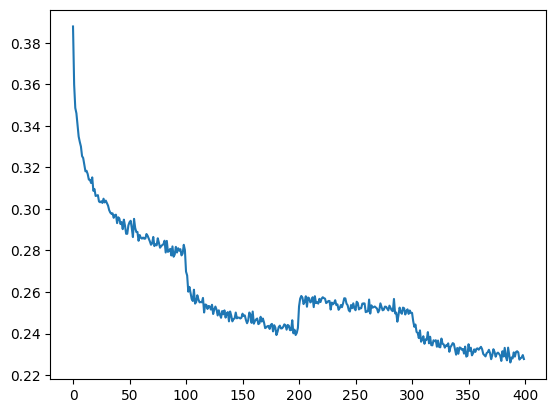

In [69]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

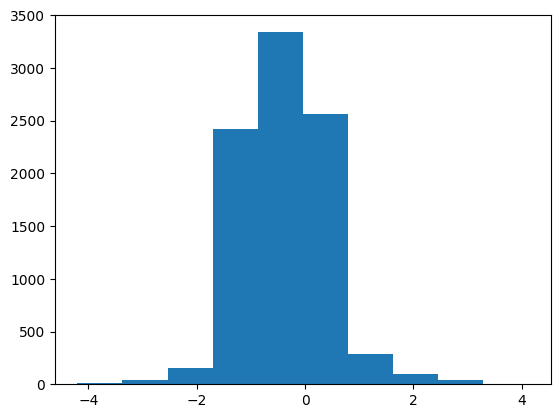

In [59]:
plt.hist(model.layers[1].layers[0].out.clone().detach().view(-1));

# plt.hist(model.layers[2].out.clone().detach().view(-1));

In [18]:
# sample from the model
def sample_from_model():
    res = []
    for _ in range(20):
        out = []
        context = [0] * block_size # initialize with all ...
        while True:
          # forward pass the neural net
          logits = model(torch.tensor([context]))
          probs = F.softmax(logits, dim=1)
          # sample from the distribution
          ix = torch.multinomial(probs, num_samples=1).item()
          # shift the context window and track the samples
          context = context[1:] + [ix]
          out.append(ix)
          # if we sample the special '.' token, break
          if ix == 0:
            break
        res.append(''.join(itos[i] for i in out)) # decode and print the generated word
    return res

### Next attempt is to using identity mapping in the residual layer. This is done in order to not add more paramters to the model because of the projection done at the residual level. 
We will make sure that the input number of channels of the residual block input is the same as the output number of channels. 
<br/> We will update the code of the residual block in order to make it so that if the in and out channels are the same, it does not do projection of the input. 
* We do not expect to see any loss improvement in this case, but we do expect to see training time reduced. 

In [90]:
# Let's increase the inchannels on every conv layer to compare parameter count
x = torch.randn((32, 10, 8))
c1 = Conv1d(8, 20, 10)
c2 = Conv1d(7, 20, 10)

resnet = Residual([
    c1, c2
])
print(f"parameters: {sum(p.nelement() for p in resnet.parameters())}")


parameters: 1030


In [91]:
# Let's keep the inchannels same on every conv layer to compare parameter count
x = torch.randn((32, 10, 8))
c1 = Conv1d(8, 10, 10)
c2 = Conv1d(7, 10, 10)

resnet = Residual([
    c1, c2
])
print(f"parameters: {sum(p.nelement() for p in resnet.parameters())}")


parameters: 420


As you can see, the parameter count is significantly lower. 

In [100]:
def get_Lout(sequence_length, kernel, dilation, stride):
    effective_kernel = (kernel - 1) * dilation + 1
    Lout = ((sequence_length - effective_kernel) // stride) + 1
    return Lout
    
### Let's redefine the model with conv layers 
n_embedding = 10

# conv1d_1
n_conv1_out_channels = 10
n_conv1_stride = 1 
n_conv1_kernel = 2
n_conv1_dilation = 1

# Compute Lout based on effective kernel using dilation, instead of actual kernel
conv1_L_out = get_Lout(block_size, n_conv1_kernel, n_conv1_dilation, n_conv1_stride)
# conv1_L_out = ((block_size - n_conv1_kernel) // n_conv1_stride) + 1
print("conv1_L_out: ", conv1_L_out)
# conv1d_2
n_conv2_out_channels = 10
n_conv2_stride = 1 
n_conv2_kernel = 3
n_conv2_dilation = 2
conv2_L_out = get_Lout(conv1_L_out, n_conv2_kernel, n_conv2_dilation, n_conv2_stride)
# conv2_L_out = ((conv1_L_out - n_conv2_kernel) // n_conv2_stride) + 1
print("conv2_L_out: ", conv2_L_out)

# conv1d_3
n_conv3_out_channels = 10
n_conv3_stride = 1 
n_conv3_kernel = 3
n_conv3_dilation = 2
conv3_L_out = get_Lout(conv2_L_out, n_conv3_kernel, n_conv3_dilation, n_conv3_stride)
# conv3_L_out = ((conv2_L_out - n_conv3_kernel) // n_conv3_stride) + 1
print("conv3_L_out: ", conv3_L_out)

#h1
n_h1_fanout = 100

#h2
n_h2_fanout = 100

model = Sequential([
    Embedding(vocab_size, n_embedding), 
    Residual([
        Conv1d(sequence_length=block_size, in_channels=n_embedding, out_channels=n_conv1_out_channels, kernel=n_conv1_kernel, stride=n_conv1_stride), ReLu(),
        Conv1d(sequence_length=conv1_L_out, in_channels=n_conv1_out_channels, out_channels=n_conv2_out_channels, kernel=n_conv2_kernel, stride=n_conv2_stride, dilation=2), ReLu(),
        Conv1d(sequence_length=conv2_L_out, in_channels=n_conv2_out_channels, out_channels=n_conv3_out_channels, kernel=n_conv3_kernel, stride=n_conv3_stride, dilation=2), 
    ]),
    ReLu(),
    # Output of residual will be the [out_channels, input_sequence_length of the layer before the residual layer]
    Flatten(), Linear(fan_in=n_conv3_out_channels * block_size, fan_out=n_h1_fanout), Tanh(),
    Linear(fan_in=n_h1_fanout, fan_out=n_h2_fanout), Tanh(),
    Linear(fan_in=n_h1_fanout, fan_out=vocab_size)
])



with torch.no_grad():
    model.layers[-1].weight *= 0.1

# parameters = [p for layer in layers for p in layer.parameters()]
print(f"parameters: {sum(p.nelement() for p in model.parameters())}")

for p in model.parameters():
    p.requires_grad = True

conv1_L_out:  14
conv2_L_out:  10
conv3_L_out:  6
parameters: 29027


In [101]:
lossi = []

In [102]:
# same optimization as last time
max_steps = 200_000
batch_size = 32
# lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function
  
  for p in model.parameters():
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.05 # step learning rate decay
  for p in model.parameters():
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  

      0/ 200000: 3.3152
  10000/ 200000: 2.0705
  20000/ 200000: 1.9496
  30000/ 200000: 2.1305
  40000/ 200000: 2.2046
  50000/ 200000: 1.7311
  60000/ 200000: 2.3502
  70000/ 200000: 1.8276
  80000/ 200000: 2.0754
  90000/ 200000: 1.7440
 100000/ 200000: 1.7872
 110000/ 200000: 1.7746
 120000/ 200000: 1.6675
 130000/ 200000: 1.8793
 140000/ 200000: 1.9258
 150000/ 200000: 1.7521
 160000/ 200000: 1.9227
 170000/ 200000: 1.7370
 180000/ 200000: 2.0329
 190000/ 200000: 1.6422


In [99]:
model.layers[1].projection_needed

False

In [103]:
split_loss('train')
split_loss('val')

train 1.89764404296875
val 2.079698085784912


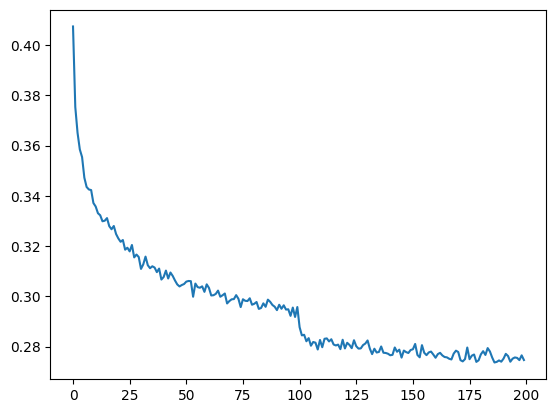

In [104]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [111]:
sample_from_model()

['stefiom.',
 'schash.',
 'rickin.',
 'kelilah.',
 'brise.',
 'hannya.',
 'anziel.',
 'demontay.',
 'mikenzeo.',
 'kailee.',
 'jale.',
 'jemmi.',
 'jeon.',
 'laurye.',
 'raini.',
 'deshanah.',
 'eloma.',
 'ariona.',
 'dimari.',
 'lovee.']

### Bottlenech architecture in residual networks
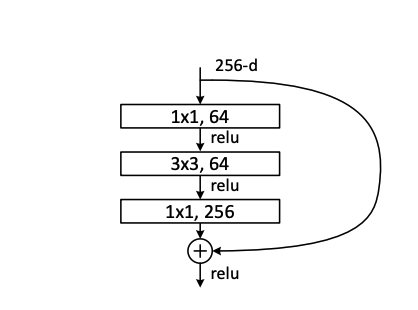

In bottleneck architecture, we reduce the channel size while passing the input to the conv layer which does the feature extraction. This enables the model to not perform the conv1 on a high dimensional data, thus reducing the time to train. 
<br/>
This will allow us to be able to make the network deeper, and yet keep the training time reduced. 
<br/> We will use 3 conv layers now, but each conv layer will be a part of a bottleneck residual layer. 
<br/> We will use 1x1 convolutional layer in order to modify the channel size. 
<br/> Here is what the model will look like (follows [N, C, L] format):
* Input [32, 10, 8]
* 1st residual block starts here
  1x1 conv1d layer reduces channel size 4. Output will be [32, 4, 8]
  <br/>3x3 conv1d layer for feature extraction with dilation 1. This will output [32, 4, 6].
  <br/>1x1 conv1d layer to upsample to the original channel size. This will output [32, 10, 6]
  <br/>Residual connection added here. Output will be [32, 10, 8]

* 2nd residual block starts here
  1x1 conv1d layer reduces channel size 4. Output will be [32, 4, 8]
  <br/>3x3 conv1d layer for feature extraction with dilation 1. This will output [32, 4, 6].
  <br/>1x1 conv1d layer to upsample to the original channel size. This will output [32, 10, 6]
  <br/>Residual connection added here. Output will be [32, 10, 8]

* 3rd residual block starts here
  1x1 conv1d layer reduces channel size 4. Output will be [32, 4, 8]
  <br/>3x3 conv1d layer for feature extraction with dilation 1. This will output [32, 4, 6].
  <br/>1x1 conv1d layer to upsample to the original channel size. This will output [32, 10, 6]
  <br/>Residual connection added here. Output will be [32, 10, 8]

In [119]:
x = torch.randn((32, 10, 8))

downconv1 = Conv1d(8, 10, 4, kernel=1)
conv1 = Conv1d(8, 4, 4, kernel=3)
upconv1 = Conv1d(6, 4, 10, kernel=1)

resnet = Residual([
    downconv1,
    conv1, 
    upconv1
])

resnet(x).shape

torch.Size([32, 10, 8])

### Let's build this!

In [123]:
def get_Lout(sequence_length, kernel, dilation, stride):
    effective_kernel = (kernel - 1) * dilation + 1
    Lout = ((sequence_length - effective_kernel) // stride) + 1
    return Lout
    
### Let's redefine the model with conv layers 
n_embedding = 24

# Residual Layer 1:
# Downsample to 4
res1_down_out_channels = 15
res1_down_stride = 1 
res1_down_kernel = 1
res1_down_dilation = 1
res1_down_Lout = get_Lout(block_size, res1_down_kernel, res1_down_dilation, res1_down_stride)

# Conv1d for feature extraction 
res1_conv_out_channels = 15
res1_conv_stride = 1 
res1_conv_kernel = 2
res1_conv_dilation = 1
res1_conv_Lout = get_Lout(res1_down_Lout, res1_conv_kernel, res1_conv_dilation, res1_conv_stride)
# Upsample to 10
res1_up_out_channels = 24
res1_up_stride = 1 
res1_up_kernel = 1
res1_up_dilation = 1
res1_up_Lout = get_Lout(res1_conv_Lout, res1_up_kernel, res1_up_dilation, res1_up_stride)

# Upsampling Layer 1x1 conv to scale to 40
up_1_out_channels = 40
up_1_stride = 1 
up_1_kernel = 1
up_1_dilation = 1
up_1_Lout = get_Lout(block_size, up_1_kernel, up_1_dilation, up_1_stride)


# Residual Layer 2:
# Downsample to 4
res2_down_out_channels = 15
res2_down_stride = 1 
res2_down_kernel = 1
res2_down_dilation = 1
res2_down_Lout = get_Lout(up_1_Lout, res2_down_kernel, res2_down_dilation, res2_down_stride)
# Conv1d for feature extraction 
res2_conv_out_channels = 15
res2_conv_stride = 1 
res2_conv_kernel = 2
res2_conv_dilation = 1
res2_conv_Lout = get_Lout(res2_down_Lout, res2_conv_kernel, res2_conv_dilation, res2_conv_stride)
# Upsample to 10
res2_up_out_channels = 40
res2_up_stride = 1 
res2_up_kernel = 1
res2_up_dilation = 1
res2_up_Lout = get_Lout(res2_conv_Lout, res2_up_kernel, res2_up_dilation, res2_up_stride)

# Upsampling Layer and 2 kernel conv to scale to 60
up_2_out_channels = 60
up_2_stride = 1 
up_2_kernel = 1
up_2_dilation = 1
up_2_Lout = get_Lout(block_size, up_2_kernel, up_2_dilation, up_2_stride)

# # Residual Layer 3:
# Downsample 
res3_down_out_channels = 30
res3_down_stride = 1 
res3_down_kernel = 1
res3_down_dilation = 1
res3_down_Lout = get_Lout(up_2_Lout, res3_down_kernel, res3_down_dilation, res3_down_stride)
# Conv1d for feature extraction 
res3_conv_out_channels = 30
res3_conv_stride = 1 
res3_conv_kernel = 3
res3_conv_dilation = 2
res3_conv_Lout = get_Lout(res3_down_Lout, res3_conv_kernel, res3_conv_dilation, res3_conv_stride)
# Upsample
res3_up_out_channels = 60
res3_up_stride = 1 
res3_up_kernel = 1
res3_up_dilation = 1
res3_up_Lout = get_Lout(res3_conv_Lout, res3_down_kernel, res3_down_dilation, res3_down_stride)


## Note: Remember that each residual layer restores the sequence length Lout to the actual sequence length (block_size), 
# due to padding and adding input to the output. Hence, commenting the Lout computation out below.


#h1
n_h1_fanout = 100

#h2
n_h2_fanout = 100

model = Sequential([
    Embedding(vocab_size, n_embedding), 

    Residual([
        Conv1d(
                sequence_length=block_size,
                in_channels=n_embedding,
                out_channels=res1_down_out_channels,
                kernel=1,
            ),
    
        # Conv Layer
        Conv1d(
                    sequence_length=res1_down_Lout,
                    in_channels=res1_down_out_channels,
                    out_channels=res1_conv_out_channels,
                    kernel=2,
                ),
        # Upsample 
        Conv1d(
                    sequence_length=res1_conv_Lout,
                    in_channels=res1_conv_out_channels,
                    out_channels=res1_up_out_channels,
                    kernel=1,
                ),
    ]),
    
    BatchNorm1d(res1_up_out_channels),
    ReLu(),
    # Up sample to 40 channels
    Conv1d(
            sequence_length=block_size,
            in_channels=res1_up_out_channels,
            out_channels=up_1_out_channels,
            kernel=1,
        ),
    ReLu(),

    Residual([
        Conv1d(
            sequence_length=block_size,
            in_channels=up_1_out_channels,
            out_channels=res2_down_out_channels,
            kernel=1,
        ), 
        # Conv 
        Conv1d(
                    sequence_length=block_size,
                    in_channels=res2_down_out_channels,
                    out_channels=res2_conv_out_channels,
                    kernel=res2_conv_kernel,
                ),
        # Up sample
        Conv1d(
                    sequence_length=res2_conv_Lout,
                    in_channels=res2_conv_out_channels,
                    out_channels=res2_up_out_channels,
                    kernel=1,
                ),
    ]),
    BatchNorm1d(res2_up_out_channels),
    ReLu(), 
    
    Conv1d(
                sequence_length=block_size,
                in_channels=res2_up_out_channels,
                out_channels=up_2_out_channels,
                kernel=up_2_kernel,
            ),

    # 3rd residual layer
        Residual([
        Conv1d(
                sequence_length=up_2_Lout,
                in_channels=up_2_out_channels,
                out_channels=res3_down_out_channels,
                kernel=1,
            ),
    
        # Conv Layer
        Conv1d(
                    sequence_length=res3_down_Lout,
                    in_channels=res3_down_out_channels,
                    out_channels=res3_conv_out_channels,
                    kernel=res3_conv_kernel,
                    dilation=res3_conv_dilation,
                ),
        # Upsample 
        Conv1d(
                    sequence_length=res3_conv_Lout,
                    in_channels=res3_conv_out_channels,
                    out_channels=res3_up_out_channels,
                    kernel=1,
                ),
    ]),
    
    BatchNorm1d(res3_up_out_channels),
    ReLu(),

            # Up sample
    Conv1d(
                sequence_length=block_size,
                in_channels=60,
                out_channels=100,
                kernel=1,
            ),

    Conv1d(
            sequence_length=block_size,
            in_channels=100,
            out_channels=100,
            kernel=2,
         ),
    
    # Output of residual will be the [out_channels, input_sequence_length of the layer before the residual layer]
    Flatten(), Linear(fan_in=14 * 100, fan_out=n_h1_fanout), Tanh(),
    Linear(fan_in=n_h1_fanout, fan_out=vocab_size)
])



with torch.no_grad():
    model.layers[-1].weight *= 0.1

# parameters = [p for layer in layers for p in layer.parameters()]
print(f"parameters: {sum(p.nelement() for p in model.parameters())}")

for p in model.parameters():
    p.requires_grad = True

parameters: 182747


In [124]:
lossi = []

In [ ]:
# same optimization as last time
max_steps = 400_000
batch_size = 32
start_time = time.time_ns()
ud = []
for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function
  
  for p in model.parameters():
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.001 if i < 200_000 else 0.0001 # step learning rate decay
  for p in model.parameters():
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

end_time = time.time_ns()
print(f"time taken to train: {(end_time - start_time) // 1_000_000_000}")

      0/ 400000: 3.2990
  10000/ 400000: 2.7225
  20000/ 400000: 2.3549
  30000/ 400000: 2.2164
  40000/ 400000: 2.2844
  50000/ 400000: 2.3766
  60000/ 400000: 2.2644
  70000/ 400000: 2.0844
  80000/ 400000: 1.9014
  90000/ 400000: 2.0940
 100000/ 400000: 1.7207
 110000/ 400000: 1.8564
 120000/ 400000: 1.9338
 130000/ 400000: 2.1857
 140000/ 400000: 2.4458
 150000/ 400000: 2.1067
 160000/ 400000: 1.8165
 170000/ 400000: 1.9621
 180000/ 400000: 1.9499
 190000/ 400000: 1.9735
 200000/ 400000: 2.7992
 210000/ 400000: 2.5366
 220000/ 400000: 2.1065
 230000/ 400000: 2.3167
 240000/ 400000: 1.7729
 250000/ 400000: 2.1643
 260000/ 400000: 1.8791
 270000/ 400000: 2.3169
 280000/ 400000: 2.0381
 290000/ 400000: 2.0050
 300000/ 400000: 2.3770
 310000/ 400000: 1.7992
 320000/ 400000: 1.9555
 330000/ 400000: 2.2644
 340000/ 400000: 2.2016
 350000/ 400000: 1.9153
 360000/ 400000: 1.8246
 370000/ 400000: 1.6188
 380000/ 400000: 1.7359


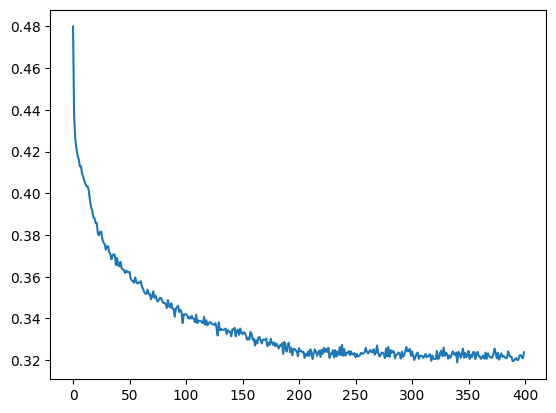

In [104]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))


In [105]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

In [106]:
for layer in model.layers:
    layer.training = False
    
split_loss('train')
split_loss('val')

train 2.099557399749756
val 2.1272685527801514


In [107]:
sample_from_model()

['darane.',
 'siah.',
 'jaycea.',
 'jauhia.',
 'amilo.',
 'kumerd.',
 'siana.',
 'kaldeah.',
 'diana.',
 'rusa.',
 'atysson.',
 'elisty.',
 'javasda.',
 'jarlyn.',
 'ashara.',
 'zardayan.',
 'graylei.',
 'anna.',
 'adi.',
 'kevi.']